<a href="https://colab.research.google.com/github/SergeySmalkov/Detector/blob/main/FRN_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.core.display import display, HTML
from scipy import signal
from numba import jit
from datetime import timedelta
from bisect import bisect_left

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
binance = pd.read_pickle('drive/MyDrive/crypto_research/binance')
binance_trades = pd.read_pickle('drive/MyDrive/crypto_research/trades_Binance')

In [75]:
# Function to get the best bid
def get_best_bid(bids):
    # The best bid is the highest price in the bids list
    # Bids list is formatted as [(price, volume),...]
    # So, we sort by price in descending order and take the first element
    best_bid = sorted(bids, key=lambda x: x[0], reverse=True)[0][0]
    return best_bid

# Function to get the best ask
def get_best_ask(asks):
    # The best ask is the lowest price in the asks list
    # Asks list is formatted as [(price, volume),...]
    # So, we sort by price in ascending order and take the first element
    best_ask = sorted(asks, key=lambda x: x[0])[0][0]
    return best_ask

# Apply these functions to your DataFrame
binance['best_bid'] = binance['bids'].apply(get_best_bid)
binance['best_ask'] = binance['asks'].apply(get_best_ask)

# The mid point of ToB is the average of the best bid and best ask
binance['mid_ToB'] = (binance['best_bid'] + binance['best_ask']) / 2
binance

,receive_timestamp,asks,bids,symbol,market,best_bid,best_ask,mid_ToB
0,2023-06-13 00:00:00.259,"[(15.2, 4847.01), (15.21, 6739.28)]","[(15.18, 2076.81), (15.17, 4800.05), (15.16, 7...",SOLUSDT,Binance,15.18,15.20,15.190
1,2023-06-13 00:00:00.657,"[(15.2, 4866.34), (15.21, 6730.65), (15.23, 18...","[(15.18, 2262.12), (15.17, 4800.05), (15.16, 7...",SOLUSDT,Binance,15.18,15.20,15.190
2,2023-06-13 00:00:00.759,"[(15.2, 4866.34), (15.21, 6730.65), (15.22, 97...","[(15.18, 2393.78), (15.17, 4800.05), (15.16, 7...",SOLUSDT,Binance,15.18,15.20,15.190
3,2023-06-13 00:00:00.963,"[(15.2, 2501.53), (15.21, 5931.88), (15.22, 89...","[(15.18, 2413.53), (15.17, 4800.05), (15.16, 6...",SOLUSDT,Binance,15.18,15.20,15.190
4,2023-06-13 00:00:01.058,"[(15.19, 100.4), (15.2, 3200.77), (15.21, 6013...","[(15.18, 2413.53), (15.17, 4740.74), (15.16, 6...",SOLUSDT,Binance,15.18,15.19,15.185
...,...,...,...,...,...,...,...,...
427037,2023-06-13 23:59:59.193,"[(15.04, 3005.95), (15.05, 3160.6), (15.06, 79...","[(15.03, 588.84), (15.02, 2836.04), (15.01, 49...",SOLUSDT,Binance,15.03,15.04,15.035
427038,2023-06-13 23:59:59.392,"[(15.04, 3004.95), (15.05, 3160.6), (15.06, 79...","[(15.03, 588.84), (15.02, 2836.04), (15.01, 49...",SOLUSDT,Binance,15.03,15.04,15.035
427039,2023-06-13 23:59:59.692,"[(15.04, 3001.38), (15.05, 3160.6), (15.06, 79...","[(15.03, 588.84), (15.02, 2836.04), (15.01, 49...",SOLUSDT,Binance,15.03,15.04,15.035
427040,2023-06-13 23:59:59.791,"[(15.04, 3001.38), (15.05, 2918.0), (15.06, 79...","[(15.03, 422.53), (15.02, 2836.04), (15.01, 49...",SOLUSDT,Binance,15.03,15.04,15.035


In [76]:
def get_events(curr_list, prev_list, side, timestamp):
    curr_dict = dict(curr_list)
    prev_dict = dict(prev_list)

    events = []

    # Check for placed and cancelled orders in current list
    for price, size in curr_dict.items():
        if price in prev_dict:
            if size > prev_dict[price]:
                events.append((timestamp, 'PLACED', side, price, size - prev_dict[price]))
            elif size < prev_dict[price]:
                events.append((timestamp, 'CANCELLED', side, price, prev_dict[price] - size))
        else:
            events.append((timestamp, 'PLACED', side, price, size))

    # Check for cancelled orders in previous list
    for price, size in prev_dict.items():
        if price not in curr_dict:
            events.append((timestamp, 'CANCELLED', side, price, size))

    return events


def create_events_table(df):
    df['asks'] = df['asks'].apply(lambda x: [(float(y[0]), float(y[1])) for y in x])
    df['bids'] = df['bids'].apply(lambda x: [(float(y[0]), float(y[1])) for y in x])

    events_data = []

    for i in range(1, len(df)):
        timestamp = df.iloc[i]['receive_timestamp']
        # Get events for asks
        events_data.extend(get_events(df.iloc[i]['asks'], df.iloc[i-1]['asks'], 'ask', timestamp))

        # Get events for bids
        events_data.extend(get_events(df.iloc[i]['bids'], df.iloc[i-1]['bids'], 'bid', timestamp))

    events_df = pd.DataFrame(events_data, columns=['timestamp', 'status', 'side', 'price', 'size'])

    return events_df



events_df = create_events_table(binance)
print(events_df)


                      timestamp     status side  price     size
0       2023-06-13 00:00:00.657     PLACED  ask  15.20    19.33
1       2023-06-13 00:00:00.657  CANCELLED  ask  15.21     8.63
2       2023-06-13 00:00:00.657     PLACED  ask  15.23  1800.00
3       2023-06-13 00:00:00.657     PLACED  bid  15.18   185.31
4       2023-06-13 00:00:00.759     PLACED  ask  15.22  9784.65
...                         ...        ...  ...    ...      ...
1609899 2023-06-13 23:59:59.791  CANCELLED  bid  15.03   166.31
1609900 2023-06-13 23:59:59.791     PLACED  bid  15.00    86.08
1609901 2023-06-13 23:59:59.791  CANCELLED  bid  14.92   345.90
1609902 2023-06-13 23:59:59.791     PLACED  bid  14.91   332.63
1609903 2023-06-13 23:59:59.891     PLACED  ask  15.04   242.60

[1609904 rows x 5 columns]


In [77]:
epsilon = 150  # in milliseconds
tick_size = 0.01

# Convert timestamp column to datetime
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])

# Initialize yellow and red card columns
events_df['yellow_card'] = 0
events_df['red_card'] = 0

events_df_bids = events_df[events_df["side"] == "bid"].copy()
events_df_asks = events_df[events_df["side"] == "ask"].copy()
events_df_bids

,timestamp,status,side,price,size,yellow_card,red_card
3,2023-06-13 00:00:00.657,PLACED,bid,15.18,185.31,0,0
6,2023-06-13 00:00:00.759,PLACED,bid,15.18,131.66,0,0
10,2023-06-13 00:00:00.963,PLACED,bid,15.18,19.75,0,0
11,2023-06-13 00:00:00.963,CANCELLED,bid,15.16,519.09,0,0
12,2023-06-13 00:00:00.963,PLACED,bid,15.15,6489.38,0,0
...,...,...,...,...,...,...,...
1609893,2023-06-13 23:59:59.392,CANCELLED,bid,14.99,464.91,0,0
1609899,2023-06-13 23:59:59.791,CANCELLED,bid,15.03,166.31,0,0
1609900,2023-06-13 23:59:59.791,PLACED,bid,15.00,86.08,0,0
1609901,2023-06-13 23:59:59.791,CANCELLED,bid,14.92,345.90,0,0


In [78]:
from numba import jit
import numpy as np

epsilon_ms = 150  # epsilon in milliseconds
tick_size = 0.01

@jit(nopython=True)
def fill_cards_numba(timestamps, statuses, prices, asks_flag):
    n = len(timestamps)

    adj_tick_size = tick_size if asks_flag else -0.01

    yellow_cards = np.zeros(n, dtype=np.int64)
    red_cards = np.zeros(n, dtype=np.int64)

    for idx in range(n):
        end_time = timestamps[idx]
        start_time = end_time - epsilon_ms

        j = idx - 1
        while j >= 0 and timestamps[j] >= start_time:
            if prices[j] == prices[idx] + adj_tick_size:
                if statuses[idx] == 1 and statuses[j] == 1:  # 'PLACED' status is encoded as 1
                    yellow_cards[j] += 1
                    red_cards[idx] += 1
                elif statuses[idx] == 0 and statuses[j] == 0:  # 'CANCELLED' status is encoded as 0
                    yellow_cards[j] += 1
                    red_cards[idx] += 1
            j -= 1
    return yellow_cards, red_cards



In [79]:
# Convert the DataFrame into numpy arrays
timestamps_bids = events_df_bids['timestamp'].values.astype(np.int64) // 10**6  # convert to milliseconds
prices_bids = events_df_bids['price'].values
statuses_bids = (events_df_bids['status'] == 'PLACED').values.astype(np.int64)  # assuming only two statuses: 'PLACED' and 'CANCELLED'

# Convert the DataFrame into numpy arrays
timestamps_asks = events_df_asks['timestamp'].values.astype(np.int64) // 10**6  # convert to milliseconds
prices_asks = events_df_asks['price'].values
statuses_asks = (events_df_asks['status'] == 'PLACED').values.astype(np.int64)  # assuming only two statuses: 'PLACED' and 'CANCELLED'

yellow_cards_bids, red_cards_bids = fill_cards_numba(timestamps_bids, statuses_bids, prices_bids, asks_flag=False)
yellow_cards_asks, red_cards_asks = fill_cards_numba(timestamps_asks, statuses_asks, prices_asks, asks_flag=True)

# Add 'yellow_card' and 'red_card' to the DataFrame
events_df_bids.loc[:, 'yellow_card'] = yellow_cards_bids
events_df_bids.loc[:, 'red_card'] = red_cards_bids
events_df_asks.loc[:, 'yellow_card'] = yellow_cards_asks
events_df_asks.loc[:, 'red_card'] = red_cards_asks


events_df_asks

,timestamp,status,side,price,size,yellow_card,red_card
0,2023-06-13 00:00:00.657,PLACED,ask,15.20,19.33,0,0
1,2023-06-13 00:00:00.657,CANCELLED,ask,15.21,8.63,0,0
2,2023-06-13 00:00:00.657,PLACED,ask,15.23,1800.00,1,0
4,2023-06-13 00:00:00.759,PLACED,ask,15.22,9784.65,0,1
5,2023-06-13 00:00:00.759,CANCELLED,ask,15.23,8.88,0,0
...,...,...,...,...,...,...,...
1609895,2023-06-13 23:59:59.692,PLACED,ask,15.08,0.98,0,0
1609896,2023-06-13 23:59:59.791,CANCELLED,ask,15.05,242.60,0,0
1609897,2023-06-13 23:59:59.791,PLACED,ask,15.35,15.00,0,0
1609898,2023-06-13 23:59:59.791,CANCELLED,ask,15.36,15.00,0,0


In [126]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from mpl_interactions import ioff, panhandler, zoom_factory

def draw_cards(from_time, to_time):
    # plt.close('all')
    # Create a new figure
    with plt.ioff():
        fig, ax = plt.subplots(figsize=(12, 8))

    disconnect_zoom = zoom_factory(ax)
    display(fig.canvas)
    ax.grid(True, which='both', axis='y', linestyle='-', linewidth=0.15)

    events_df_bids_temp = events_df_bids[events_df_bids["timestamp"] > from_time]
    events_df_bids_temp = events_df_bids_temp[events_df_bids_temp["timestamp"] < to_time]

    events_df_asks_temp = events_df_asks[events_df_asks["timestamp"] > from_time]
    events_df_asks_temp = events_df_asks_temp[events_df_asks_temp["timestamp"] < to_time]


    mid_ToB_df = binance[(binance['receive_timestamp'] > from_time) & (binance['receive_timestamp'] < to_time)]
    trades_df = binance_trades[(binance_trades['receive_timestamp'] > from_time) & (binance_trades['receive_timestamp'] < to_time)]

    marker_edge_width = 0.15  # Adjust this value to your liking
    marker_edge_width_wide = 1
    marker_face_color = 'none'
    marker_size = 70

    for maker_side, marker_edge_color, label in zip(['Ask', 'Bid'], ['green', 'red'], ['Aggressive Buy', 'Aggressive Sell']):
        trades_temp = trades_df[trades_df["maker_side"] == maker_side]
        ax.scatter(trades_temp['receive_timestamp'], trades_temp['price'], s=marker_size,
                  facecolors=marker_face_color, edgecolors=marker_edge_color, linewidths=marker_edge_width_wide, label=label)

    marker_edge_color = 'black'

    # Plot data for bids
    for df, marker, color in zip([events_df_bids_temp], ['^'], ['g']):
        no_card = df[(df['status'] == 'PLACED') & (df['yellow_card'] == 0) & (df['red_card'] == 0)]
        yellow_card = df[(df['status'] == 'PLACED') & (df['yellow_card'] > 0)]
        red_card = df[(df['status'] == 'PLACED') & (df['red_card'] > 0)]

        ax.scatter(no_card['timestamp'], no_card['price'], marker=marker, color=color,
                   label='No card', edgecolors=marker_edge_color, linewidths=marker_edge_width)
        ax.scatter(yellow_card['timestamp'], yellow_card['price'], marker=marker, color='yellow',
                   label='Yellow card', edgecolors=marker_edge_color, linewidths=marker_edge_width)
        ax.scatter(red_card['timestamp'], red_card['price'], marker=marker, color='red', s=50,
                   label='Red card', edgecolors=marker_edge_color, linewidths=marker_edge_width)  # s changes size

    # Plot data for bids
    for df, marker, color in zip([events_df_bids_temp], ['2'], ['g']):
        no_card = df[(df['status'] == 'CANCELLED') & (df['yellow_card'] == 0) & (df['red_card'] == 0)]
        yellow_card = df[(df['status'] == 'CANCELLED') & (df['yellow_card'] > 0)]
        red_card = df[(df['status'] == 'CANCELLED') & (df['red_card'] > 0)]

        ax.scatter(no_card['timestamp'], no_card['price'], marker=marker, color=color,
                   label='No card',  linewidths=marker_edge_width_wide)
        ax.scatter(yellow_card['timestamp'], yellow_card['price'], marker=marker, color='yellow',
                   label='Yellow card',  linewidths=marker_edge_width_wide)
        ax.scatter(red_card['timestamp'], red_card['price'], marker=marker, color='red', s=50,
                   label='Red card', linewidths=marker_edge_width_wide)  # s changes size


    # Plot data for asks
    for df, marker, color in zip([events_df_asks_temp], ['v'], ['g']):
        no_card = df[(df['status'] == 'PLACED') & (df['yellow_card'] == 0) & (df['red_card'] == 0)]
        yellow_card = df[(df['status'] == 'PLACED') & (df['yellow_card'] > 0)]
        red_card = df[(df['status'] == 'PLACED') & (df['red_card'] > 0)]

        ax.scatter(no_card['timestamp'], no_card['price'], marker=marker, color=color,
                   label='_No card', edgecolors=marker_edge_color, linewidths=marker_edge_width)  # labels with underscores are not shown in the legend
        ax.scatter(yellow_card['timestamp'], yellow_card['price'], marker=marker, color='yellow',
                   label='_Yellow card', edgecolors=marker_edge_color, linewidths=marker_edge_width)
        ax.scatter(red_card['timestamp'], red_card['price'], marker=marker, color='red', s=50,
                   label='_Red card', edgecolors=marker_edge_color, linewidths=marker_edge_width)  # s changes size

    # Plot data for asks
    for df, marker, color in zip([events_df_asks_temp], ['1'], ['g']):
        no_card = df[(df['status'] == 'CANCELLED') & (df['yellow_card'] == 0) & (df['red_card'] == 0)]
        yellow_card = df[(df['status'] == 'CANCELLED') & (df['yellow_card'] > 0)]
        red_card = df[(df['status'] == 'CANCELLED') & (df['red_card'] > 0)]

        ax.scatter(no_card['timestamp'], no_card['price'], marker=marker, color=color,
                   label='_No card', linewidths=marker_edge_width_wide)  # labels with underscores are not shown in the legend
        ax.scatter(yellow_card['timestamp'], yellow_card['price'], marker=marker, color='yellow',
                   label='_Yellow card',  linewidths=marker_edge_width_wide)
        ax.scatter(red_card['timestamp'], red_card['price'], marker=marker, color='red', s=50,
                   label='_Red card', linewidths=marker_edge_width_wide)  # s changes size

    ax.plot(mid_ToB_df['receive_timestamp'], mid_ToB_df['mid_ToB'], color='blue', label='Mid ToB', drawstyle='steps-post')
    ax.plot(mid_ToB_df['receive_timestamp'], mid_ToB_df['best_bid'], color='grey', label='Best Bid', drawstyle='steps-post')
    ax.plot(mid_ToB_df['receive_timestamp'], mid_ToB_df['best_ask'], color='grey', label='Best Ask', drawstyle='steps-post')

    # Set title and labels
    ax.set_title('Market events')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Price')
    plt.xticks(rotation=45)
    fig.autofmt_xdate()

    # Set the date formatter based on the time difference
    time_diff = (datetime.strptime(to_time, "%Y-%m-%d %H:%M:%S.%f") - datetime.strptime(from_time, "%Y-%m-%d %H:%M:%S.%f")).total_seconds()
    if time_diff <= 2:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
    elif time_diff <= 300:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    else:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Add legend
    ax.legend()



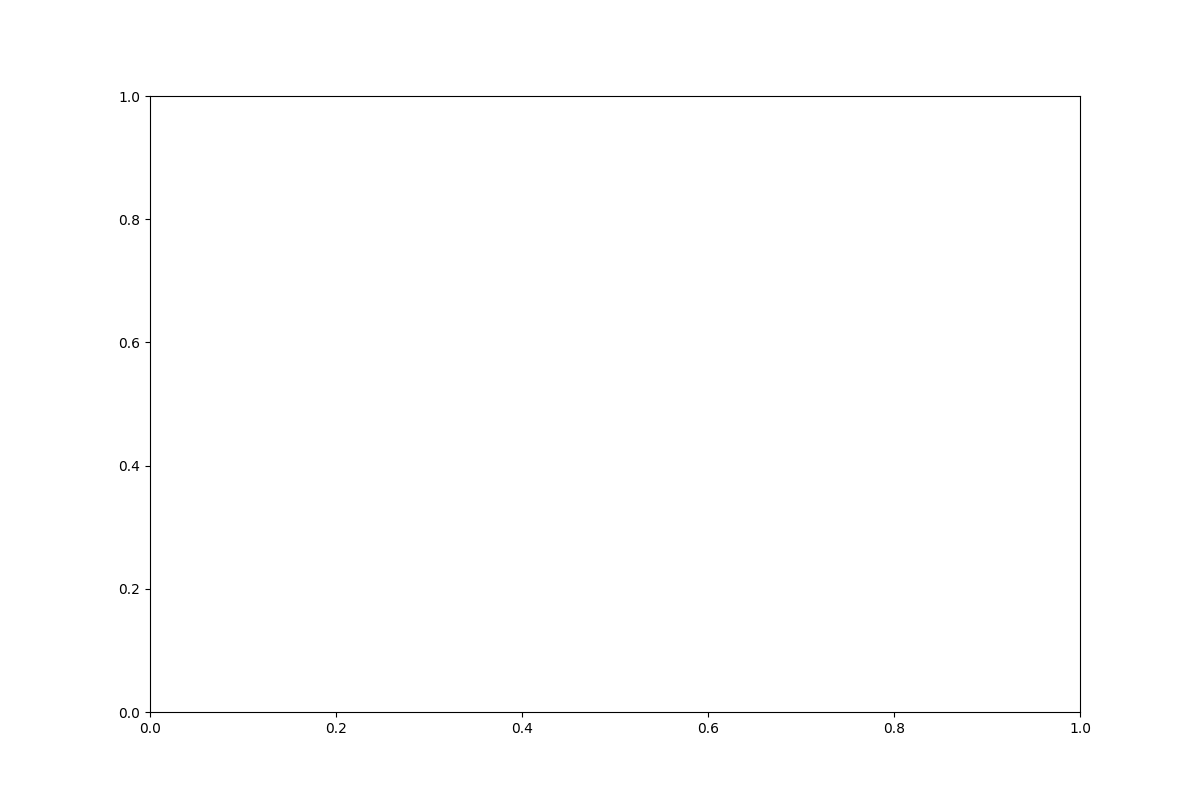

In [127]:
draw_cards("2023-06-13 00:00:03.000", "2023-06-13 00:00:08.157")

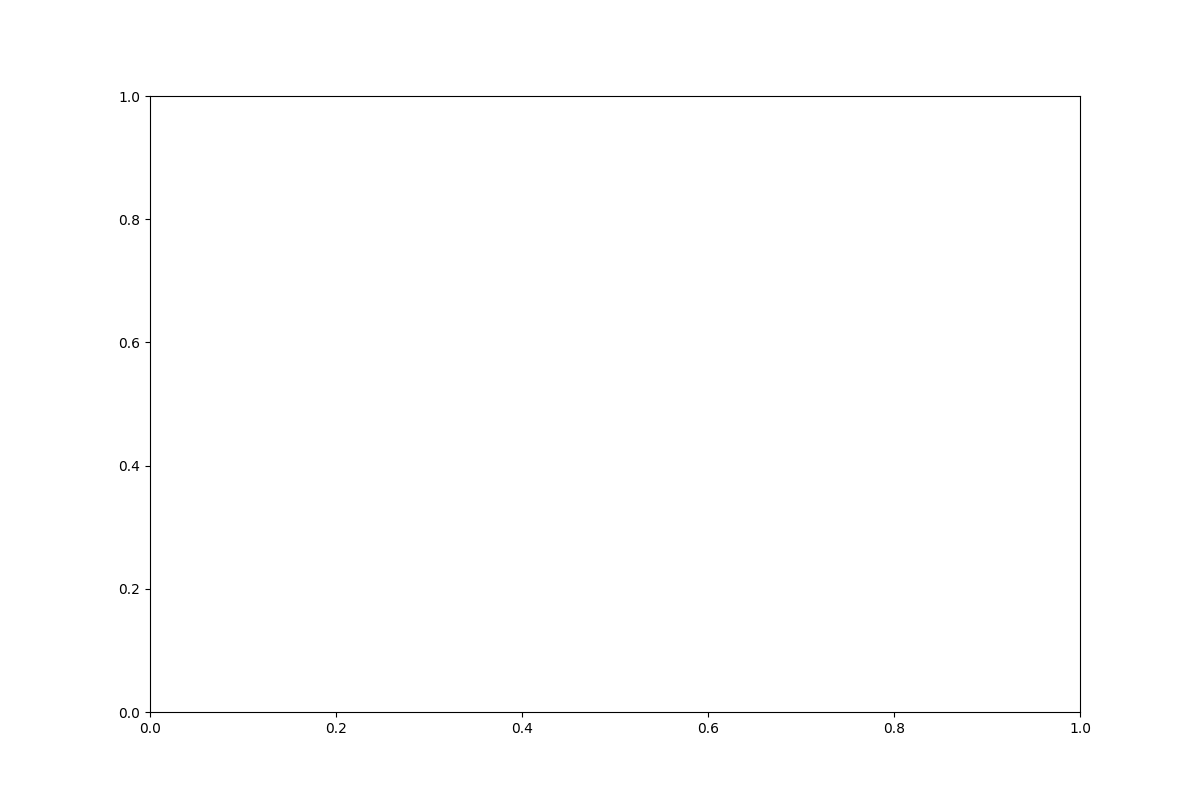

In [128]:
draw_cards("2023-06-13 00:00:00.000", "2023-06-13 00:00:55.157")

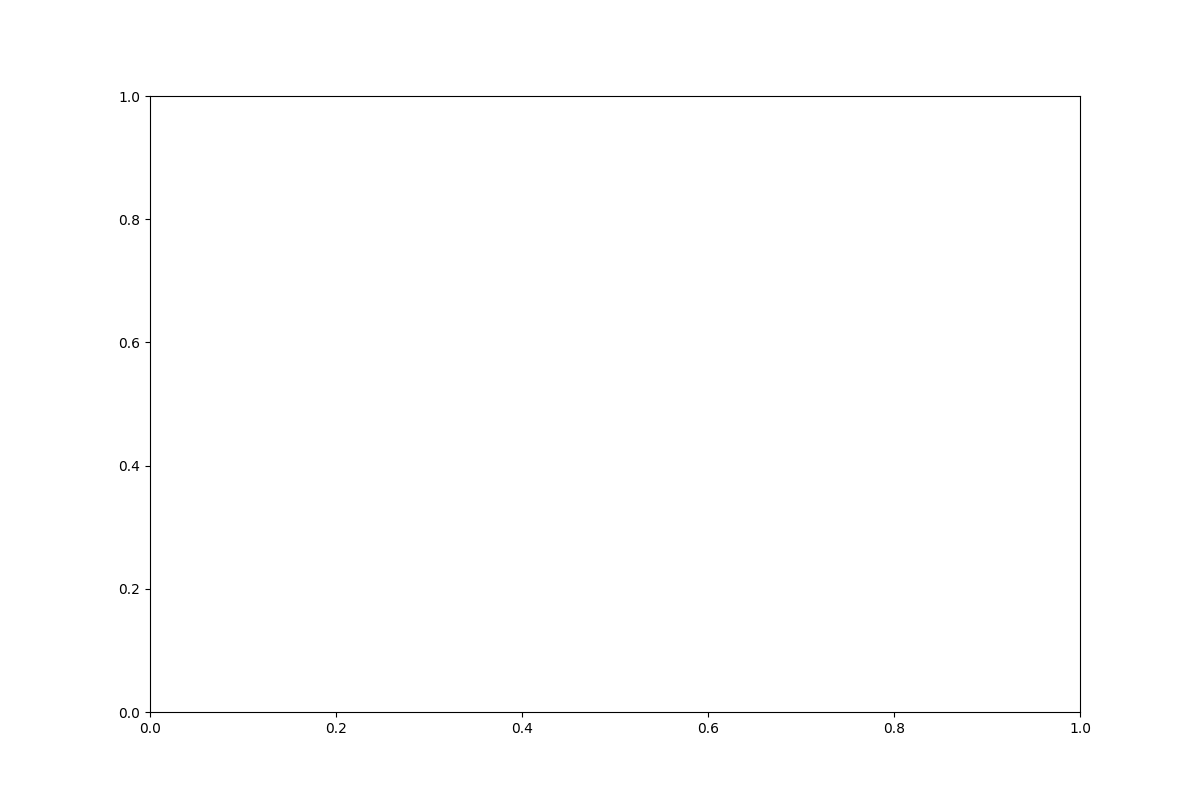

In [129]:
draw_cards("2023-06-13 00:00:00.657", "2023-06-13 00:05:35.657")

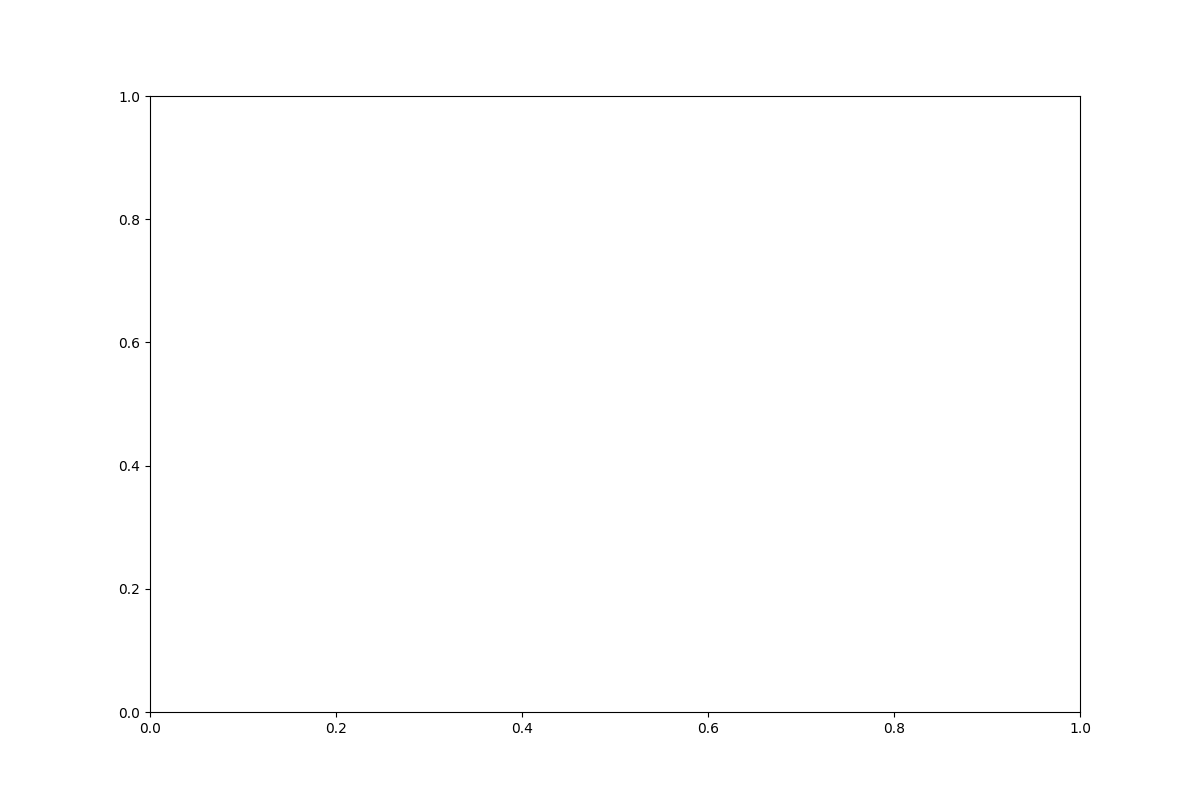

In [130]:
draw_cards("2023-06-13 00:00:00.657", "2023-06-13 20:05:35.657")